In [67]:
#Bibliotecas
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from tqdm import tqdm
from itertools import compress
import seaborn as sns
import random
sns.set_theme()

In [21]:
#Se crea una función para verificar la completitud de las variables de la base.
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"variable",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

In [15]:
sp500_data =pd.read_csv('DJ30.csv', index_col=0)
sp500_data

,Company,Symbol
#,,
1,UnitedHealth Group Incorporated,UNH
2,Goldman Sachs Group Inc.,GS
3,Home Depot Inc.,HD
4,Amgen Inc.,AMGN
5,McDonald's Corporation,MCD
6,Microsoft Corporation,MSFT
7,Caterpillar Inc.,CAT
8,Honeywell International Inc.,HON
9,Visa Inc. Class A,V


In [16]:
#Nos quedamos solo con el símbolo de la compañía
sp_list = sp500_data['Symbol'].to_list()
print(sp_list[:10])

['UNH', 'GS', 'HD', 'AMGN', 'MCD', 'MSFT', 'CAT', 'HON', 'V', 'TRV']


In [17]:
#Descargamos la información para cada activo desde yfinance
ohlc = yf.download(sp_list, period="2y")

[*********************100%***********************]  30 of 30 completed


In [18]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.shape

(505, 30)

In [19]:
prices.tail(3)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-13,153.850006,241.530014,181.330002,215.649994,248.149994,171.080002,47.860001,169.511475,107.660004,60.320000,...,109.550003,270.642120,125.150002,140.070007,187.600006,495.350006,228.880005,40.320000,36.625298,145.910004
2023-02-14,153.199997,241.029999,181.020004,218.449997,244.360001,169.960007,47.700001,170.810013,107.660004,59.759998,...,108.739998,271.490021,126.199997,139.279999,184.130005,492.829987,229.389999,40.330002,36.270000,145.490005
2023-02-15,155.330002,240.070007,180.669998,217.440002,248.699997,171.100006,48.450001,169.009995,109.239998,59.759998,...,107.680000,269.320007,127.480003,138.960007,185.220001,491.250000,228.919998,40.380001,36.520000,146.570007


In [22]:
#Se descartan las opciones que tienen poco tiempo en el mercado
#(no debería de hacerse mucho enfasis en esta parte)
cc =completitud(prices)
cc.head(5)

,variable,total,completitud
0,AAPL,0,100.0
1,VZ,0,100.0
2,V,0,100.0
3,UNH,0,100.0
4,TRV,0,100.0


In [23]:
sp500_names_reduc = cc[cc['completitud' ]>99]['variable'].values
prices_selection = prices[sp500_names_reduc]

In [24]:
prices_selection.dropna(inplace=True) #borra nulos
prices_selection.isna().sum().sum()   #revisar que ya no queden más valores nulos

0

In [28]:
#Calculo de rendimientos logaritmicos 
log_rend = prices_selection.copy()
for asset in prices_selection.columns:
  log_rend[asset] =  np.log(prices_selection[asset]/prices_selection[asset].shift(1))

log_rend.dropna(inplace=True)
log_rend.shape

(504, 30)

<AxesSubplot:>

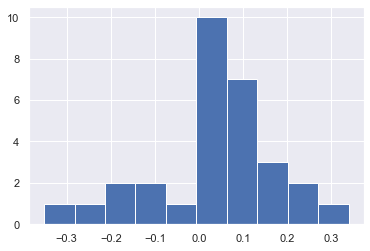

In [29]:
(log_rend.mean()*252).hist()

<AxesSubplot:>

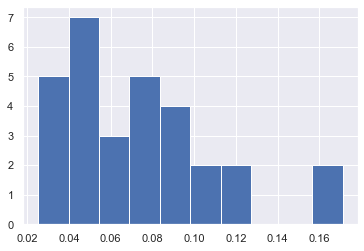

In [32]:
(log_rend.var()*252).hist()

In [33]:
import pandas as pd
assets_ind_perf=pd.DataFrame()
assets_ind_perf["mean"]=-log_rend.mean()
assets_ind_perf["variance"]=log_rend.std()
assets_ind_perf

,mean,variance
AAPL,-0.000329,0.019261
VZ,0.000379,0.012102
V,-0.000219,0.017134
UNH,-0.000875,0.013863
TRV,-0.000539,0.014050
PG,-0.000263,0.011737
NKE,0.000174,0.022353
MSFT,-0.000238,0.018678
MRK,-0.000964,0.013769
MMM,0.000727,0.015047


In [35]:
means = log_rend.mean().to_numpy()
cov_matrix = log_rend.cov().to_numpy()

In [37]:
#Esta función se ajusta a mano dependiendo de cuantos activos tengas
ref_dirs = get_reference_directions("uniform", len(means), n_points = 278256)
len(ref_dirs)

278256

In [107]:
class PBIL_CCPS():
    
    def __init__(self, assets_dict, returns, risk, K, POP, lamb):
        self.assets_dict = assets_dict #Diccionario indice -nombre de la accion 
        self.returns = returns         # Retornos
        self.risk = risk               # Matriz de varianzas y covarianzas
        self.k    = K                  #Activos a considerar en un portafolio
        self.N    = len(assets_dict)   #Total de activos
        self.POP  = POP
        self.lamb = lamb
        
    def initialize_population(self): 
        #Construye asignaciones de Z y X aleatorias 
        self.Z = np.zeros((self.POP,self.N))
        self.X = np.zeros((self.POP,self.N))
        for i in range(self.POP): 
            select = random.sample(range(self.N), self.k)
            self.Z[i, select] = 1 
            self.X[i, select] = np.random.uniform(size=self.k)
        #Inicializar el vector de probabilidades 
        self.P = np.array([0.5]*self.POP)
        self.Xmeans = np.array([0.5]*self.POP)
        self.Xstd  = np.sqrt(np.sum( (self.X - np.array([self.Xmeans]).transpose())**2, axis=1) /self.POP)
    
    def eval_portfolios(self): 
        self.f = []
        for i in range(self.POP): 
            self.f.append(self.lamb* (self.X[i,:]@self.risk @ self.X[i,:])-(1-self.lamb)*(self.X[i,:]@self.returns) )

    def eval_assets(self): 
        phi = (1-self.lamb)*self.returns
        cissigma = self.lamb*np.sum(self.risk, axis=1)
        min_phi = np.min(0, np.min(phi))
        min_cissigma =np.min(0, np.min(cissigma))
        self.Prating = (1+ phi -min_phi )/ (1+cissigma +min_cissigma)

    
    
    
    
    